Now let's compute or robust version of the Q-Learning algorithm (in finite spaces)

Import all useful libraries

In [1]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
import copy 
import random
import pandas as pd
from tqdm import tqdm
from scipy.stats import binom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Import the q-learning function

In [2]:
from robust_q_learning_v2 import *

"Robust" Settings

First tests

In [3]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P1_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5)

# Adding some robustness to the model of a "fair coin"
eps = 0.1
def Pp_0(x,a):
    return binom.rvs(nr_coins, 0.5 + eps)
def pp_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5 + eps)
def Pm_0(x,a):
    return binom.rvs(nr_coins, 0.5 - eps)
def pm_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5 - eps)

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

In [4]:
Nr_iter = 100_000

Q_opt_robust_, Visits = robust_q_learning_v2(X, A, r, np.array([P1_0, Pm_0, Pp_0]), np.array([p1_0, pm_0, pp_0]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 100000/100000 [02:35<00:00, 643.80it/s]


In [5]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [6]:
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
df

,State,0,1,2,3,4,5,6,7,8,9,10
0,"Robust, finite spaces",1,1,1,1,0,0,0,-1,-1,-1,-1


In [7]:
Visits

array([[6.0000e+00, 8.0000e+01, 1.0000e+02],
       [5.6000e+01, 1.0000e+02, 1.2690e+03],
       [1.6600e+02, 1.8200e+02, 4.8310e+03],
       [3.9900e+02, 4.0300e+02, 1.1290e+04],
       [6.5900e+02, 1.8204e+04, 6.5800e+02],
       [7.6800e+02, 2.1417e+04, 7.6800e+02],
       [6.6900e+02, 1.8462e+04, 6.3600e+02],
       [1.0461e+04, 1.1320e+03, 4.3300e+02],
       [4.9300e+03, 1.5300e+02, 1.6100e+02],
       [1.3210e+03, 5.4000e+01, 3.7000e+01],
       [1.8100e+02, 7.0000e+00, 7.0000e+00]])

Study of the sensitivity to the size of the probability range and the number of probabilities considered

First initialize our Q with the non-robust algorithm!

In [8]:
from q_learning import *

nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000
Q_opt_nonrobust = q_learning(X, A, r, P_0, alpha, x_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

100%|██████████| 100000/100000 [00:05<00:00, 18492.18it/s]


Then study the impact of the transition kernel

In [9]:
from tqdm import tqdm  #reinitialize tqdm

In [10]:
EPS  = [1, 2, 0.5]
Nr_p = [2, 5, 10, 25, 50, 100]
    
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x, a, y):
    return(a * (y > x) - a * (y < x) - np.abs(a) * (x == y)) # Reward function

def P1_0(x, a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y, nr_coins,0.5)


# Adding some robustness to the model of a "fair coin"
eps     = EPS[0] / nr_coins
nr_prob = Nr_p[5]
P       = [P1_0]
p       = [p1_0]
for n in range(1, nr_prob//2 + 1):
    def Pp(x,a):
        return binom.rvs(nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    P += [Pp]
    def pp(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 + (eps * n / (nr_prob//2)))
    p += [pp]
    def Pm(x,a):
        return binom.rvs(nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    P += [Pm]
    def pm(x,a,y):
        return binom.pmf(y, nr_coins, 0.5 - (eps * n / (nr_prob//2)))
    p += [pm]
print(len(P))     # Verification

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust__, Visits_ = robust_q_learning_v2(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = Q_opt_nonrobust)

101


100%|██████████| 100000/100000 [1:30:12<00:00, 18.48it/s]


In [11]:
# Build the functions that allow us to get the index of an element a (reps. x) in A (resp. X)
if np.ndim(A) > 1:
    A_list = A
else:
    A_list = np.array([[a] for a in A])
if np.ndim(X) > 1:
    X_list = X
else:
    X_list = np.array([[x] for x in X])

def a_index(a):
    return np.flatnonzero((a==A_list).all(1))[0]
def x_index(x):
    return np.flatnonzero((x==X_list).all(1))[0]

# Get the result of the Q-Learning algorithm,
# Get the optimal results for each x in X
def a_opt(x, Q_opt):
    return A[np.argmax(Q_opt[x_index(x),:])]

In [12]:
df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust__) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
df

,State,0,1,2,3,4,5,6,7,8,9,10
0,"Robust, finite spaces",1,1,1,1,0,0,0,-1,-1,-1,-1


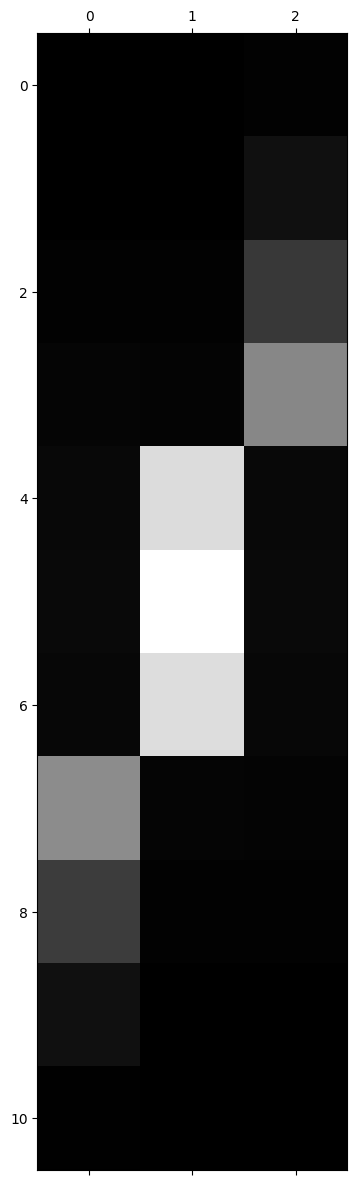

In [13]:
plt.matshow(Visits_, cmap='gray')

In [14]:
Visits_

array([[3.0000e+00, 5.0000e+00, 1.9400e+02],
       [4.0000e+01, 3.5000e+01, 1.3940e+03],
       [1.9100e+02, 1.8700e+02, 4.7350e+03],
       [4.4600e+02, 3.6600e+02, 1.1197e+04],
       [6.7500e+02, 1.8145e+04, 7.1700e+02],
       [8.0800e+02, 2.1111e+04, 7.7800e+02],
       [6.5000e+02, 1.8282e+04, 6.3900e+02],
       [1.1619e+04, 4.3700e+02, 3.8100e+02],
       [4.9910e+03, 1.7000e+02, 1.6900e+02],
       [1.3680e+03, 4.9000e+01, 4.8000e+01],
       [1.5600e+02, 5.0000e+00, 9.0000e+00]])

And finally comparison with -Julian Sester- Wassersstein uncertainty

In [15]:
from julian_sester__Q_learning import *
from tqdm import tqdm  #reinitialize tqdm

In [16]:
EPS  = [1, 2, 0.5]
    
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def c(x, y):
    return np.abs(x-y)

def r(x, a, y):
    return(a * (y > x) - a * (y < x) - np.abs(a) * (x == y)) # Reward function

def P1_0(x, a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y, nr_coins,0.5)


# Adding some robustness to the model of a "fair coin"
epsilon = EPS[0]

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_js = js_robust_q_learning(X, A, r, c, P1_0, p1_0, epsilon, alpha, x_0, eps_greedy, Nr_iter, q = 1, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_js) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 100000/100000 [04:59<00:00, 333.96it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  0  0  0  0  0  0  0  0  0  0   0


Some other tests

With other types of probability distribution of the range of probabilities itself

non_symmetric range:

In [17]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

def P1_0(x,a):
    return binom.rvs(nr_coins, 0.5) # Assumption that is a fair coin
def p1_0(x,a,y):
    return binom.pmf(y,nr_coins,0.5)

# Adding some robustness to the model of a "fair coin"
def P2_0(x,a):
    return binom.rvs(nr_coins, 0.6)
def p2_0(x,a,y):
    return binom.pmf(y,nr_coins,0.6)
alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_, Visits = robust_q_learning_v2(X, A, r, np.array([P1_0, P2_0]), np.array([p1_0, p2_0]), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 100000/100000 [01:45<00:00, 946.02it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  1  0  0 -1 -1 -1  -1


normally distributed range:

In [18]:
nr_coins = 10
X        = np.linspace(0, nr_coins, nr_coins+1)        # States
A        = np.array([-1, 0, 1])                        # Actions

def r(x,a,y):
    return(a * (y>x) - a * (y<x) - np.abs(a) * (x==y)) # Reward function

L = np.random.normal(0.5, 0.05, 25)

P = []
p = []
for p_ in L:
    def P_0(x,a):
        return binom.rvs(nr_coins, p_)
    P += [P_0]
    def p_0(x,a,y):
        return binom.pmf(y,nr_coins, p_)
    p += [p_0]

alpha      = 0.95 # Discount Factor
x_0        = 5    # Initial Value
k_0        = 0    # Initial index of the corresponding MDP, starting with the central proba of 1/2
eps_greedy = 0.1  # Epsilon greedy policy

Nr_iter = 100_000

Q_opt_robust_, Visits = robust_q_learning_v2(X, A, r, np.array(P), np.array(p), alpha, x_0, k_0, eps_greedy, Nr_iter, gamma_t_tilde = lambda t: 1/(t+1), Q_0 = np.ones([len(X),len(A)]))

df = pd.DataFrame(np.array([[a_opt(x, Q_opt_robust_) for x in X]]))
df["State"]=["Robust, finite spaces"]
df = df.set_index("State").reset_index()
print(df)

100%|██████████| 100000/100000 [23:47<00:00, 70.07it/s]

                   State  0  1  2  3  4  5  6  7  8  9  10
0  Robust, finite spaces  1  1  1  1  0  0 -1 -1 -1 -1  -1
